In [154]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
from pathlib import Path
from data_loader.dataLoader import KaggleCSVLoader

from scipy.stats import gaussian_kde, norm
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

PROJECT_ROOT = Path().resolve()
sys.path.append(str(PROJECT_ROOT))

## Fetching Data

In [15]:
# Loading Kaggle Data
DATASET_NAME = "dhrubangtalukdar/fortune-500-companies-stock-data"

loader = KaggleCSVLoader(
    dataset_name=DATASET_NAME,
    raw_data_dir='data/raw'
)

stock_data = loader.run() # stock_data: dict[str, pd.DataFrame]

CVS files already exist. Skipping download.
Loading NVR.csv
Loading Halliburton.csv
Loading Altria_Group.csv
Loading Paccar.csv
Loading Constellation_Energy.csv
Loading Cintas.csv
Loading Warner_Bros_Discovery.csv
Loading EMCOR_Group.csv
Loading Northern_Trust.csv
Loading Gilead_Sciences.csv
Loading Mastercard.csv
Loading Thermo_Fisher_Scientific.csv
Loading Devon_Energy.csv
Loading United_Rentals.csv
Loading Thor_Industries.csv
Loading CBRE_Group.csv
Loading Genuine_Parts.csv
Loading Voya_Financial.csv
Loading Unum_Group.csv
Loading Carrier_Global.csv
Loading Fox.csv
Loading Corebridge_Financial.csv
Loading AutoZone.csv
Loading Huntington_Ingalls_Industries.csv
Loading Charter_Communications.csv
Loading Micron_Technology.csv
Loading Ross_Stores.csv
Loading Elevance_Health.csv
Loading Newmont.csv
Loading Lincoln_National.csv
Loading HCA_Healthcare.csv
Loading PepsiCo.csv
Loading Global_Payments.csv
Loading Alaska_Air_Group.csv
Loading Starbucks.csv
Loading Lithia_Motors.csv
Loading Afl

## Data Cleansing

In [16]:
# Required columns that have to be present in each stock data
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adjusted_Close', 'Volume', 'Ticker']

# Checking ticker columns and datetime column dtypes
valid_data = {}
invalid_tickers = []

for ticker, df in stock_data.items():
    # Check the missing columns
    if (not set(cols).issubset(df.columns)):
        invalid_tickers.append((ticker, 'Missing columns'))
        continue
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        invalid_tickers.append((ticker, 'Date not datetime'))
        continue

    valid_data[ticker] = df

print(f"Valid tickers: {len(valid_data)} \t Invalid tickers: {len(invalid_tickers)}")

# Remove duplicates & sort values based on date
for ticker, df in valid_data.items():
    df = (
        df
        .drop_duplicates(subset=['Date'])
        .sort_values('Date')
        .reset_index(drop=True)
    )

    valid_data[ticker] = df

### Data manipulation
# Enforcing data dtypes
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted_Close']
enforced_data = {}

for ticker, df in valid_data.items():
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors = 'coerce')

    enforced_data[ticker] = df

# Handling missing data
handled_data = {}
min_length_data = {}
min_length = 252 # Nb. of trading days in a year

for ticker, df in enforced_data.items():
    price_cols = ['Open', 'High', 'Low', 'Close']
    df[price_cols] = df[price_cols].ffill()
    df['Volume'] = df['Volume'].fillna(0)
    
    # dropping NAs at the start of series
    df = df.dropna()

    if len(df) < min_length:
        min_length_data[ticker] = df
        continue

    handled_data[ticker] = df

print(f"Nb. of tickers with insufficient history {len(min_length_data)}")

# Sanity on logical expressions
def sanityCheck(df):
    return(
        (df['High'] >= df['Low']).all()
        and (df['Close'] > 0).all()
        and (df['Volume'] >= 0).all()
    )

clean_data = {
    t: df for t, df in handled_data.items() if sanityCheck(df)
}

dirty_data = {
    t: df for t, df in handled_data.items() if not(sanityCheck(df))
}
print(f"Clean tickers: {len(clean_data)} \t Dirty tickers: {len(dirty_data)}")

# Concatenating the tickers within the clean_data dictionary
clean_data_df = pd.concat(
    clean_data.values(),
    ignore_index = True
)

clean_data_df.groupby('Ticker').size().sort_values()

Valid tickers: 461 	 Invalid tickers: 0
Nb. of tickers with insufficient history 1
Clean tickers: 460 	 Dirty tickers: 0


Ticker
Ingram_Micro_Holding             296
GE_Vernova                       442
Solventum                        443
BrightSpring_Health_Services     484
KLA                              572
                                ... 
CHS                             2784
Kellanova                       2785
QVC_Group                       2795
Air_Products_and_Chemicals      2795
Seaboard                        2795
Length: 460, dtype: int64

In [17]:
# Saving the processed data to dedicated folder
processed_dir = Path("data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

clean_data_df.to_csv(
    processed_dir / "fortune_500_cleaned.csv",
    index = False
)

for ticker, df in clean_data.items():
    df.to_csv(
        processed_dir / f"{ticker}_cleaned.csv",
        index = False
    )

## Time-Series Preprocessing

In [18]:
# Feature parameters
"""
window_return: daily / weekly / monthly
window_volume: short / medium / long
"""
window_return = [1, 5, 20]  
window_volume = [5, 20, 60]

# Feature engineering
feature_data = {}

for ticker, df in clean_data.items():
    df = df.copy()

    # Ensuring non-negative Adjusted_Close
    df = df[df['Adjusted_Close'] > 0].copy()

    # Returns
    df.loc[:, 'log_return_1d'] = np.log(df['Adjusted_Close']).diff()
    
    for r in window_return[1:]:
        df.loc[:, f'log_return_{r}d'] = np.log(df['Adjusted_Close']).diff(r)
    
    # Volatility
    for v in window_volume[:]:
        df.loc[:, f'volatility_{v}d'] = df['log_return_1d'].rolling(v).std()
    
    # Simple Return
    df.loc[:, 'simple_return_1d'] = df['Adjusted_Close'].pct_change()

    # Drawdown
    rolling_max = df['Adjusted_Close'].cummax()
    df.loc[:, 'drawdown'] = (df['Adjusted_Close'] - rolling_max) / rolling_max

    # Drop NAs
    df = df.dropna().reset_index(drop=True)

    feature_data[ticker] = df

# Concatenating the tickers within the feature_data dictionary
feature_data_df = pd.concat(
    feature_data.values(),
    ignore_index = True
)

feature_data_df.head()

,Date,Open,High,Low,Close,Adjusted_Close,Volume,Ticker,log_return_1d,log_return_5d,log_return_20d,volatility_5d,volatility_20d,volatility_60d,simple_return_1d,drawdown
0,2015-03-31,1334.000000,1349.979980,1312.020020,1328.660034,1328.660034,33400.0,NVR,-0.007005,-0.008252,0.005578,0.006922,0.009038,0.011859,-0.006981,-0.022325
1,2015-04-01,1324.079956,1330.150024,1313.010010,1329.819946,1329.819946,24200.0,NVR,0.000873,0.001008,0.007412,0.005820,0.009034,0.011857,0.000873,-0.021472
2,2015-04-02,1325.520020,1356.000000,1317.609985,1353.130005,1353.130005,36000.0,NVR,0.017377,0.022776,0.011820,0.008869,0.009404,0.012023,0.017529,-0.004319
3,2015-04-06,1349.020020,1369.130005,1345.750000,1359.239990,1359.239990,55300.0,NVR,0.004505,0.021296,0.019524,0.008834,0.009398,0.011729,0.004515,0.000000
4,2015-04-07,1355.010010,1356.900024,1321.729980,1333.989990,1333.989990,30700.0,NVR,-0.018751,-0.003002,0.002244,0.013434,0.010378,0.011763,-0.018577,-0.018577


In [19]:
# Saving the processed data to dedicated folder
feature_data_df.to_csv(
    processed_dir / "fortune_500_features.csv",
    index = False
)

for ticker, df in feature_data.items():
    df.to_csv(
        processed_dir / f"{ticker}_feature.csv",
        index = True
    )


## Exploratory Time-Series & Volatility Analysis

In [20]:
# Data Overview
print(feature_data_df.info())
feature_data_df.describe(percentiles=[0.01, 0.05, 0.95, 0.99])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182490 entries, 0 to 1182489
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Date              1182490 non-null  datetime64[ns]
 1   Open              1182490 non-null  float64       
 2   High              1182490 non-null  float64       
 3   Low               1182490 non-null  float64       
 4   Close             1182490 non-null  float64       
 5   Adjusted_Close    1182490 non-null  float64       
 6   Volume            1182490 non-null  float64       
 7   Ticker            1182490 non-null  object        
 8   log_return_1d     1182490 non-null  float64       
 9   log_return_5d     1182490 non-null  float64       
 10  log_return_20d    1182490 non-null  float64       
 11  volatility_5d     1182490 non-null  float64       
 12  volatility_20d    1182490 non-null  float64       
 13  volatility_60d    1182490 non-null  float6

,Date,Open,High,Low,Close,Adjusted_Close,Volume,log_return_1d,log_return_5d,log_return_20d,volatility_5d,volatility_20d,volatility_60d,simple_return_1d,drawdown
count,1182490,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06
mean,2020-09-22 03:46:05.243511040,1.353062e+02,1.367426e+02,1.338630e+02,1.353236e+02,5.000066e+15,6.811757e+06,3.256722e-04,1.648235e-03,6.555766e-03,1.771166e-02,1.934089e-02,2.021773e-02,6.319077e-04,-1.903384e-01
min,2015-03-27 00:00:00,3.500000e-03,3.500000e-03,3.500000e-03,3.500000e-03,3.500000e-03,0.000000e+00,-1.325161e+01,-1.325161e+01,-1.596843e+01,0.000000e+00,0.000000e+00,0.000000e+00,-9.999982e-01,-1.000000e+00
1%,2015-05-11 00:00:00,3.170000e+00,3.250000e+00,3.090000e+00,3.170000e+00,3.230000e+00,0.000000e+00,-6.342443e-02,-1.451269e-01,-2.838415e-01,2.650488e-03,5.547407e-03,6.940049e-03,-6.145496e-02,-8.434113e-01
5%,2015-10-22 00:00:00,1.400000e+01,1.424000e+01,1.376000e+01,1.399000e+01,1.195897e+01,2.110000e+05,-3.169397e-02,-7.271396e-02,-1.397739e-01,4.787353e-03,7.678349e-03,9.126052e-03,-3.119699e-02,-6.051333e-01
50%,2020-10-14 00:00:00,7.026000e+01,7.108000e+01,6.947000e+01,7.027000e+01,6.190458e+01,2.229900e+06,6.012386e-04,3.151949e-03,1.070698e-02,1.391128e-02,1.607536e-02,1.705245e-02,6.014194e-04,-1.278124e-01
95%,2025-06-27 00:00:00,3.549900e+02,3.588510e+02,3.508800e+02,3.548800e+02,3.454738e+02,2.167071e+07,3.119863e-02,7.177122e-02,1.472889e-01,4.183314e-02,4.043781e-02,4.112619e-02,3.169040e-02,-7.015432e-05
99%,2025-11-21 00:00:00,1.339751e+03,1.352240e+03,1.325823e+03,1.341090e+03,1.512120e+03,7.501988e+07,6.153346e-02,1.342050e-01,2.561166e-01,7.533965e-02,7.138657e-02,6.674440e-02,6.346608e-02,0.000000e+00
max,2025-12-30 00:00:00,9.914170e+03,9.964770e+03,9.794000e+03,9.924400e+03,3.775871e+19,3.692928e+09,1.349927e+00,2.222304e+00,2.222304e+00,5.926298e+00,2.987741e+00,1.736561e+00,2.857143e+00,0.000000e+00
std,NaN,3.407874e+02,3.438802e+02,3.378088e+02,3.408529e+02,3.936023e+17,2.835731e+07,3.206903e-02,7.125977e-02,1.436657e-01,2.679805e-02,2.558235e-02,2.484592e-02,2.348374e-02,1.936086e-01


#### Distribution of Returns

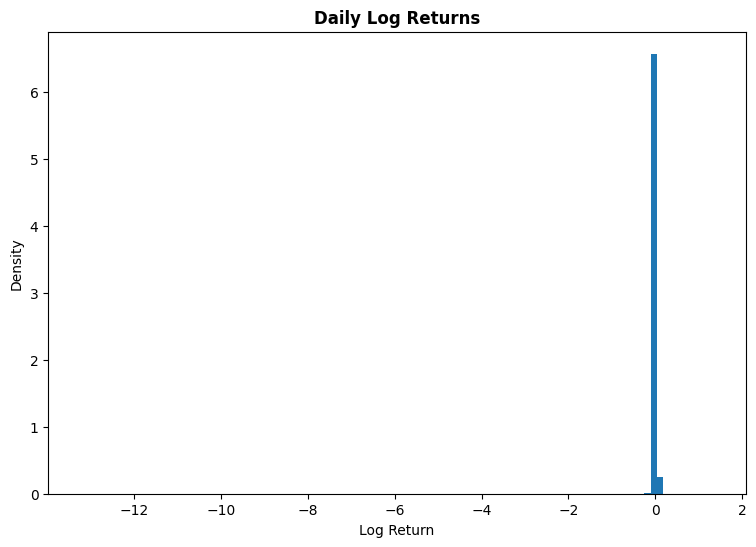

In [21]:
# Visualizing log returns
returns = feature_data_df['log_return_1d'].copy()

plt.figure(figsize=(9,6))
plt.hist(
    returns,
    bins = 100, 
    density = True
)
plt.title("Daily Log Returns", fontweight = 'bold')
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.show()

we observe that there is outliers in the daily log returns. Log return with ~ -13 means that the simple return is $\exp^{-13} \approx 0.000002$, which represents 99.9998% drop for a Fortune 500 stock. 

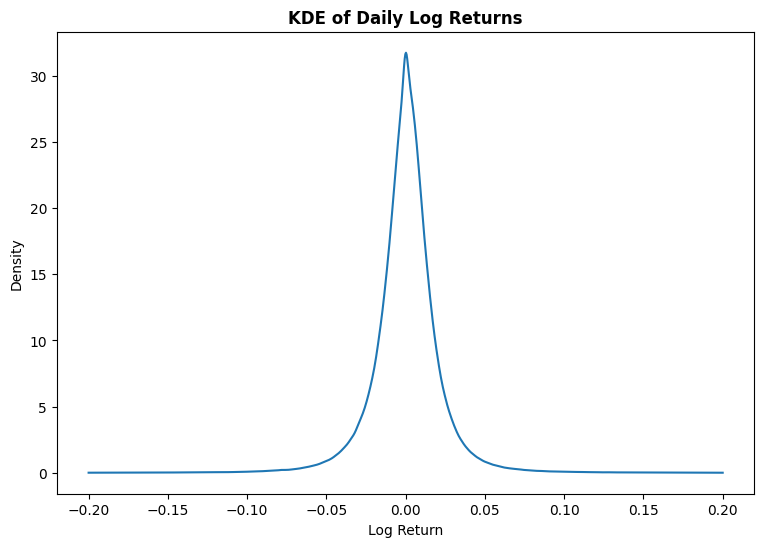

In [22]:
# Visualizing log returns
filtered_returns = returns[
    (returns > -0.2) & (returns < 0.2)
]

kde = gaussian_kde(filtered_returns)
x = np.linspace(-0.2, 0.2, 1000)

plt.figure(figsize=(9,6))
plt.plot(x, kde(x))
plt.title("KDE of Daily Log Returns", fontweight = 'bold')
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.show()

In [23]:
# Removing the outliers on 1d log returns in the feature dataset
feature_data_df = feature_data_df[
    feature_data_df['log_return_1d'].between(-1, 1)
]

for ticker, df in feature_data.items():
    df = df.copy()
    feature_data[ticker] = df[df['log_return_1d'].abs() < 1]

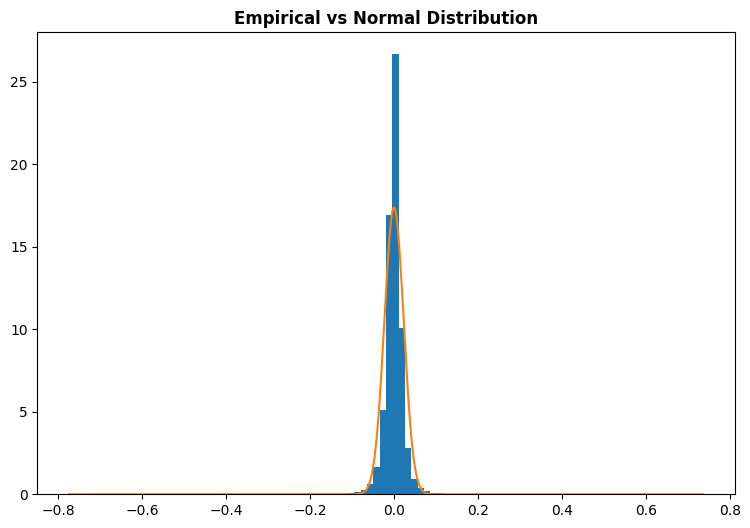

In [24]:
# Visuaizing Normal vs. Empirical distribution of returns
returns = feature_data_df['log_return_1d'].copy()
x = np.linspace(returns.min(), returns.max(), 1000)

plt.figure(figsize=(9,6))
plt.hist(
    returns,
    bins = 100, 
    density = True
)
plt.plot(
    x,
    norm.pdf(
        x,
        returns.mean(),
        returns.std()
    )
)
plt.title('Empirical vs Normal Distribution', fontweight = 'bold')
plt.show()

#### Volatility Clustering

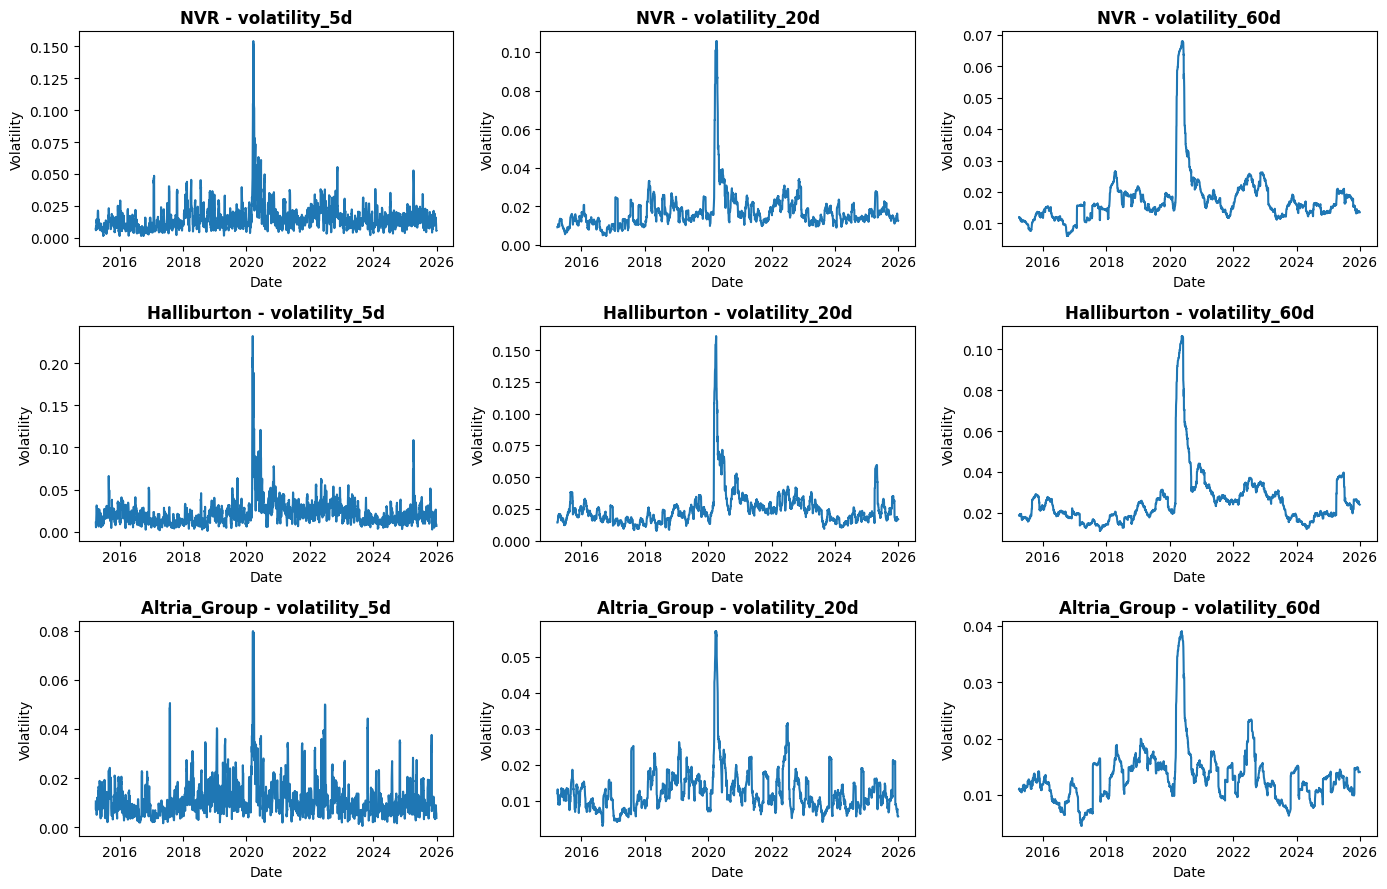

In [25]:
# Selecting first 3 tickers
sample_tickers = list(feature_data.keys())[0:3]

vol_cols = ['volatility_5d', 'volatility_20d', 'volatility_60d']

fig, axes = plt.subplots(
    nrows = 3,
    ncols = 3,
    figsize = (14,9),
    sharex = False
)

for i, ticker in enumerate(sample_tickers):
    df = feature_data[ticker]

    for j, vol_col in enumerate(vol_cols):
        ax = axes[i, j]

        ax.plot(df['Date'], df[vol_col])
        ax.set_title(f'{ticker} - {vol_col}', fontweight = 'bold')
        ax.set_ylabel('Volatility')
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

Volatility exhibits strong temporal clustering across all examined stocks. Short-horizon volatility reacts sharply to market shocks, while longer-horizon volatility captures persistent risk regimes. This behavior is consistent with financial returns and motivates conditional volatility modeling.

#### Autocorrelation Analysis

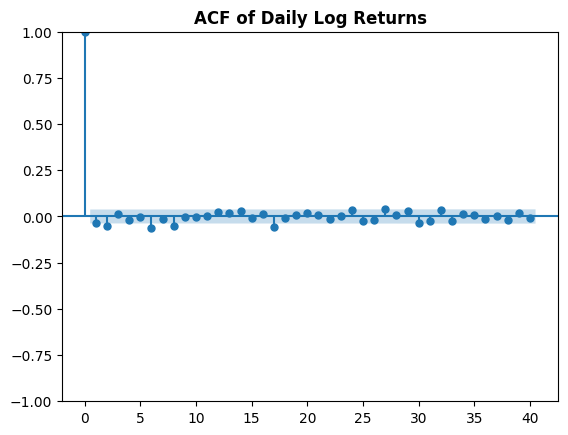

In [27]:
# Returns ACF
sample_ticker = list(feature_data.keys())[0]
sample_df = feature_data_df[feature_data_df["Ticker"] == sample_ticker]

plot_acf(sample_df['log_return_1d'], lags = 40)
plt.title('ACF of Daily Log Returns', fontweight = 'bold')
plt.show()

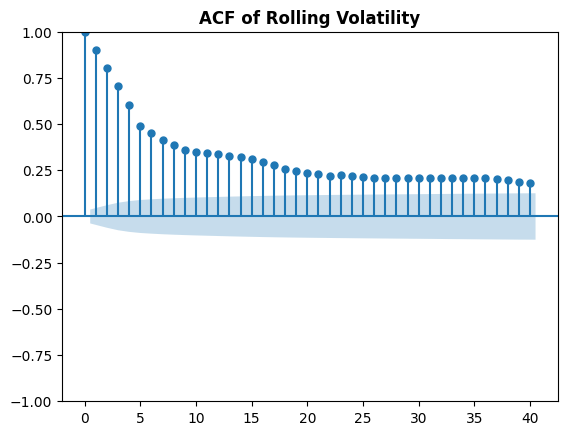

In [28]:
# Volatility ACF
plot_acf(sample_df['volatility_5d'], lags = 40)
plt.title('ACF of Rolling Volatility', fontweight = 'bold')
plt.show()

In [29]:
# Volatility distribution by ticker
vol_summary_table = feature_data_df.groupby('Ticker').agg({
    'volatility_20d': 'mean'
}).sort_values(by = 'volatility_20d',ascending = False) # ranking companies by risk

vol_summary_table

,volatility_20d
Ticker,
Ace_Hardware,0.214433
Carvana,0.053642
Oscar_Health,0.047292
Community_Health_Systems,0.047281
Altice_USA,0.044674
...,...
Procter_and_Gamble,0.010362
Johnson_and_Johnson,0.010255
Coca-Cola,0.009867


#### Drawdown Analysis

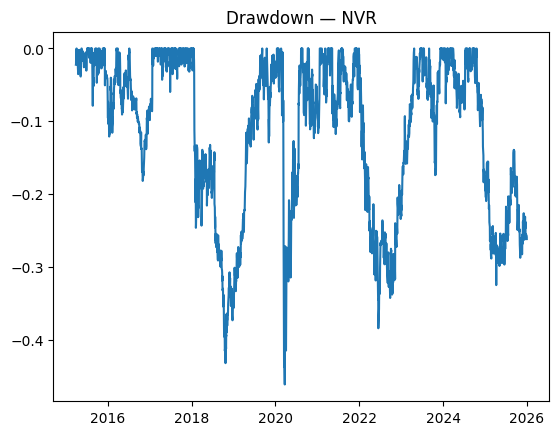

In [30]:
# Drawdown visualization
plt.plot(sample_df["Date"], sample_df["drawdown"])
plt.title(f"Drawdown — {sample_ticker}")
plt.show()

#### Correlation of Returns

In [33]:
# Computing correlation matrix
returns_pivot_table = feature_data_df.pivot(
    index = 'Date',
    columns = 'Ticker',
    values = 'log_return_1d'
)

corr_matrix = returns_pivot_table.corr()
corr_matrix.index.name = 'Ticker_1'
corr_matrix.columns.name = 'Ticker_2'
corr_matrix

Ticker_2,3M,A-Mark_Precious_Metals,ABM_Industries,AECOM,AES,AGCO,AIG,APA,ARKO,ATandT,...,Williams-Sonoma,Workday,World_Kinect,XPO,Xcel_Energy,Xylem,Yum_Brands,Yum_China_Holdings,Zimmer_Biomet_Holdings,Zoetis
Ticker_1,,,,,,,,,,,,,,,,,,,,,
3M,1.000000,0.016786,0.402162,0.437535,0.338723,0.448168,0.445837,0.320078,0.186183,0.356329,...,0.363454,0.254780,0.338237,0.351815,0.307542,0.561323,0.366455,0.215166,0.362832,0.364244
A-Mark_Precious_Metals,0.016786,1.000000,-0.041454,-0.002068,-0.008240,0.040456,-0.025130,-0.001132,-0.054644,0.074329,...,0.006717,-0.026927,0.005003,0.014216,0.033824,0.039818,0.041411,0.026110,0.066006,-0.008855
ABM_Industries,0.402162,-0.041454,1.000000,0.461154,0.361685,0.422874,0.469086,0.282637,0.201633,0.350735,...,0.284516,0.259986,0.360422,0.347759,0.328009,0.475184,0.324279,0.216083,0.345913,0.307000
AECOM,0.437535,-0.002068,0.461154,1.000000,0.456099,0.561045,0.579857,0.462329,0.214971,0.327990,...,0.412346,0.356214,0.415094,0.470462,0.243790,0.595069,0.408631,0.247801,0.432367,0.374253
AES,0.338723,-0.008240,0.361685,0.456099,1.000000,0.405689,0.425742,0.364628,0.188514,0.293803,...,0.338359,0.289441,0.316035,0.318066,0.399615,0.433692,0.363691,0.224944,0.376138,0.337254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xylem,0.561323,0.039818,0.475184,0.595069,0.433692,0.552917,0.527821,0.340728,0.188514,0.372767,...,0.393436,0.365983,0.393734,0.494001,0.337204,1.000000,0.432778,0.274704,0.425014,0.447546
Yum_Brands,0.366455,0.041411,0.324279,0.408631,0.363691,0.359706,0.456122,0.294522,0.100404,0.316272,...,0.283475,0.332563,0.252134,0.327099,0.343489,0.432778,1.000000,0.358979,0.416462,0.408732
Yum_China_Holdings,0.215166,0.026110,0.216083,0.247801,0.224944,0.263958,0.245947,0.169989,0.118852,0.152143,...,0.200959,0.250688,0.203977,0.268899,0.096884,0.274704,0.358979,1.000000,0.238380,0.277231


In [ ]:
### Extracting strong positive and negative correlated tickers
# thresholds
pos_thresh = 0.8
neg_thresh = -0.8

corr_pairs = corr_matrix.stack().reset_index(name = 'Correlation')
corr_pairs = corr_pairs[
    corr_pairs['Ticker_1'] != corr_pairs['Ticker_2']
]

# dropping duplicate pairs
corr_pairs['Pair'] = corr_pairs.apply(
    lambda x: tuple(sorted([x['Ticker_1'], x['Ticker_2']])),
    axis = 1
)
corr_pairs = corr_pairs.drop_duplicates(subset='Pair')
corr_pairs = corr_pairs.drop(columns = 'Pair')

# strongly positively correlated tickers
strongly_positive_corr = corr_pairs[corr_pairs['Correlation'] >= pos_thresh].sort_values(by='Correlation')

# strongly negatively correlated tickers
strongly_negative_corr = corr_pairs[corr_pairs['Correlation'] <= neg_thresh].sort_values(by='Correlation')

print(f'Length of strongly positively correlated tickers: {len(strongly_positive_corr)}')
print(f'Length of strongly negatively correlated tickers: {len(strongly_negative_corr)}')

strongly_positive_corr.head(10)

Length of strongly positively correlated tickers: 144
Length of strongly negatively correlated tickers: 0


,Ticker_1,Ticker_2,Correlation
15535,Ameriprise_Financial,Raymond_James_Financial,0.800210
82565,Fifth_Third_Bancorp,JPMorgan_Chase,0.800229
26491,Bank_of_America,M_and_T_Bank,0.800472
153115,PNC_Financial_Services_Group,Wells_Fargo,0.800509
49116,Citigroup,Regions_Financial,0.800522
48860,Citigroup,Citizens_Financial_Group,0.800939
59726,DR_Horton,Taylor_Morrison_Home,0.801996
26504,Bank_of_America,MetLife,0.802583
8873,Alaska_Air_Group,Delta_Air_Lines,0.802653
144780,Northern_Trust,State_Street,0.803126


The correlation structure reveals strong positive relationships primarily among firms with similar sectoral exposure.

#### Time-varying Correlations

In [61]:
# Selecting one strongly positively, one negatively correlated pairs if any available
pos_pair = strongly_positive_corr.iloc[0][['Ticker_1', 'Ticker_2']].to_list() if len(strongly_positive_corr) > 0 else None
neg_pair = strongly_negative_corr.iloc[0][['Ticker_1', 'Ticker_2']].to_list() if len(strongly_negative_corr) > 0 else None

print(f'Positive pair: {pos_pair}')
print(f'Negative pair: {neg_pair}')

# preparing pivot table
returns_matrix = feature_data_df.pivot(
    index = 'Date',
    columns = 'Ticker',
    values = 'log_return_1d'
).dropna()

# rolling correlation function
rolling_window = 60
def rolling_corr(df, t1, t2, window):
    return df[t1].rolling(window).corr(df[t2])

returns_matrix

Positive pair: ['Ameriprise_Financial', 'Raymond_James_Financial']
Negative pair: None


Ticker,3M,A-Mark_Precious_Metals,ABM_Industries,AECOM,AES,AGCO,AIG,APA,ARKO,ATandT,...,Williams-Sonoma,Workday,World_Kinect,XPO,Xcel_Energy,Xylem,Yum_Brands,Yum_China_Holdings,Zimmer_Biomet_Holdings,Zoetis
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-27,0.008323,0.016349,0.013240,0.005156,-0.008361,-0.001561,-0.004482,0.005944,-0.009132,0.002853,...,0.014043,0.000674,0.000710,0.026308,0.000443,-0.009855,0.009206,0.001344,-0.003057,0.002436
2025-06-30,0.001446,-0.010870,0.017737,0.000620,-0.018833,0.007297,0.011752,-0.014654,-0.030270,0.030167,...,-0.005189,0.011019,0.006369,-0.009379,0.004710,0.008774,-0.001551,0.000895,-0.002737,-0.001410
2025-07-01,0.010260,0.016261,0.006545,0.009699,0.023486,0.045943,0.003266,0.034921,0.086026,-0.002075,...,0.035005,-0.003214,0.023014,0.024791,0.008918,0.012598,0.014671,0.021463,0.030768,0.020563
2025-07-02,0.001040,0.016000,0.015867,0.006662,0.032880,0.023244,-0.041735,0.028625,0.002167,-0.019934,...,0.023309,-0.006248,0.018781,0.023211,-0.016879,0.005405,-0.001265,0.005893,-0.005971,-0.000691
2025-07-03,-0.006712,0.010527,-0.001772,0.011207,0.034441,-0.007719,0.009907,0.002050,0.004320,0.001765,...,0.000058,0.016768,0.002365,-0.002796,0.009282,0.004318,-0.001199,-0.004144,0.001817,0.000628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-05,-0.010631,-0.007491,0.007647,-0.026303,-0.000718,-0.005023,-0.003240,0.014496,0.004098,-0.004342,...,0.015168,0.015301,0.007463,0.014589,-0.007615,-0.013292,-0.006189,-0.007972,0.011951,-0.014725
2025-12-08,-0.021241,0.000000,-0.008325,-0.009614,-0.004320,-0.009738,-0.009391,-0.036067,-0.008214,-0.017558,...,0.000502,0.004717,-0.015820,-0.014732,-0.018966,-0.004976,-0.016905,-0.004770,-0.016361,-0.004138
2025-12-09,0.006868,-0.007547,0.008997,-0.011799,0.007189,-0.002209,0.001440,0.009518,0.014330,-0.013374,...,0.005723,0.005640,0.018296,0.013471,-0.000132,-0.009954,0.003572,0.000000,-0.005189,-0.020607


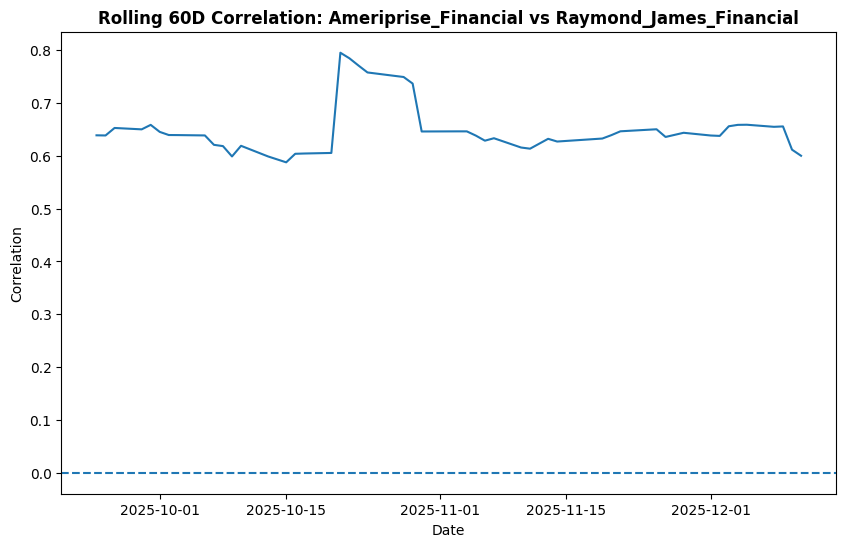

In [70]:
# Visualizing positive pair rolling correlation
if pos_pair is not None:
    rolling_pos_corr = rolling_corr(
        returns_matrix,
        pos_pair[0],
        pos_pair[1],
        rolling_window
    )

    plt.figure(figsize=(10, 6))
    plt.plot(rolling_pos_corr)
    plt.axhline(0, linestyle = '--')
    plt.title(f'Rolling {rolling_window}D Correlation: {pos_pair[0]} vs {pos_pair[1]}', fontweight = 'bold')
    plt.ylabel('Correlation')
    plt.xlabel('Date')
    plt.show()
else:
    print(f'Positive Pair doesn\'t exist!')


In [71]:
# Visualizing negative pair rolling correlation
if neg_pair is not None:
    rolling_neg_corr = rolling_corr(
        returns_matrix,
        neg_pair[0],
        neg_pair[1],
        rolling_window
    )

    plt.figure(figsize=(10, 6))
    plt.plot(rolling_neg_corr)
    plt.axhline(0, linestyle = '--')
    plt.title(f'Rolling {rolling_window}D Correlation: {neg_pair[0]} vs {neg_pair[1]}', fontweight = 'bold')
    plt.ylabel('Correlation')
    plt.xlabel('Date')
    plt.show()
else:
    print(f'Negative Pair doesn\'t exist!')

Negative Pair doesn't exist!


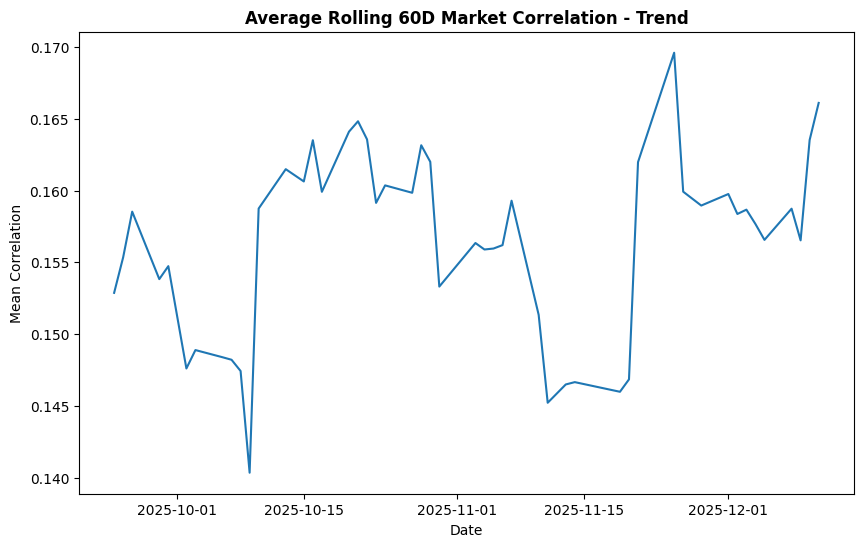

In [95]:
# Visualizing average market correlation - Trend
rolling_mean_corr_trend = (
    returns_matrix
    .rolling(rolling_window)
    .corr()
    .groupby(level=0)
    .mean()
    .mean(axis=1)
)

plt.figure(figsize=(10, 6))
plt.plot(rolling_mean_corr_trend)
plt.title(f'Average Rolling {rolling_window}D Market Correlation - Trend', fontweight = 'bold')
plt.ylabel('Mean Correlation')
plt.xlabel('Date')
plt.show()

Rolling correlation analysis reveals significant time variation in equity return dependence. Correlations increase sharply during periods of market stress.

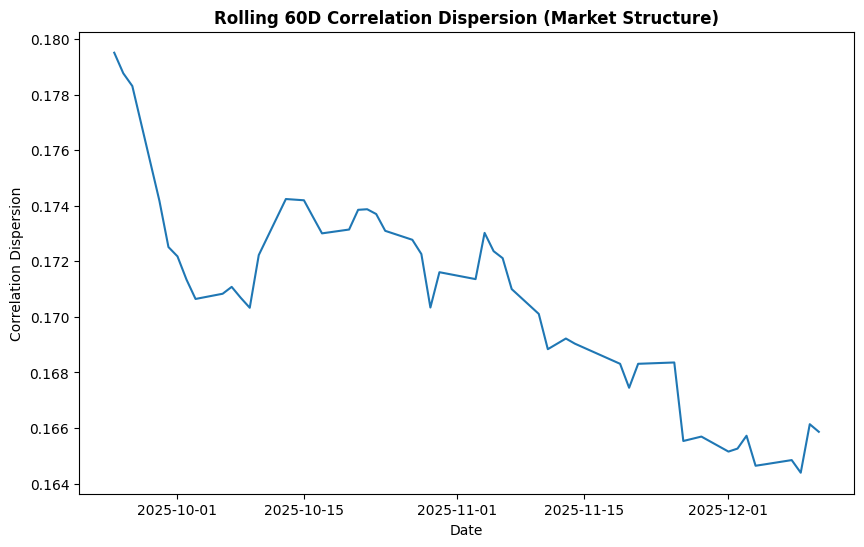

In [ ]:
# Visualizing average market correlation - Dispersion (structural instability)
rolling_mean_corr_dispersion = (
    returns_matrix
    .rolling(rolling_window)
    .corr()
    .groupby(level=0)
    .std()
    .mean(axis=1)
)

plt.figure(figsize=(10, 6))
plt.plot(rolling_mean_corr_dispersion)
plt.title(f'Rolling {rolling_window}D Correlation Dispersion (Market Structure)', fontweight = 'bold')
plt.ylabel('Correlation Dispersion')
plt.xlabel('Date')
plt.show()

The cross-sectional dispersion of rolling correlations captures the stability of market dependence structure.

## Volatility & Risk Modelling

#### Historical Volatility

Historical volatiity is the rolling standard deviatin of returns, and is computed as:
$\sigma_{t} = \sqrt{252} * std(r_{t-n:t})$

In [98]:
# computing historical volatility
trading_days = 252 # in a year
annualization = np.sqrt(trading_days)
window_vol = 20 # 1 trading month

feature_data_hv = {}

for ticker, df in feature_data.items():
    df = df.copy()

    df['hist_vol_20d'] = (
        annualization * 
        df['log_return_1d']
        .rolling(window_vol)
        .std()
    )

    feature_data_hv[ticker] = df.dropna()

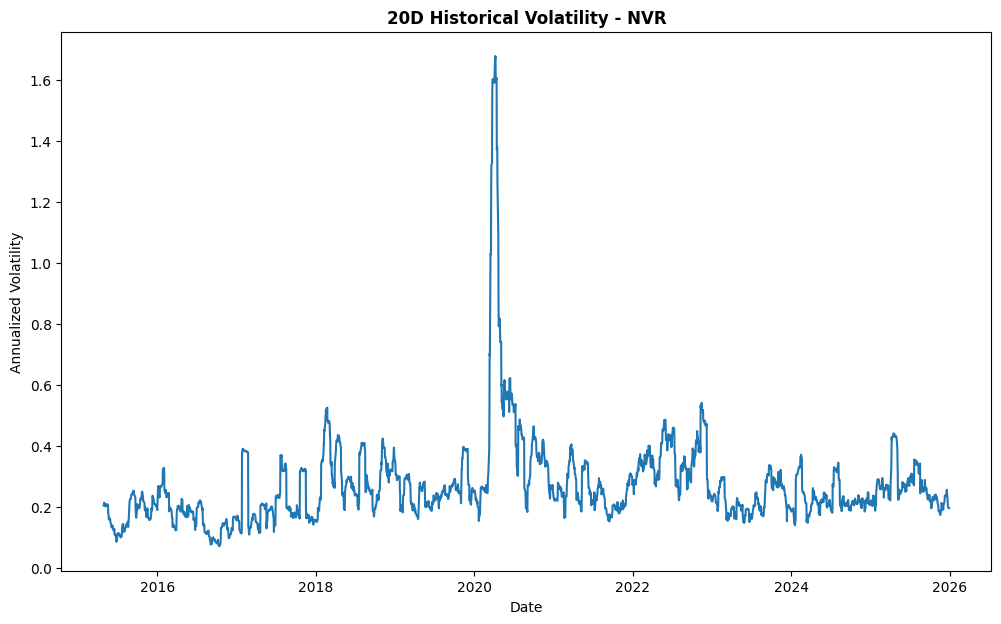

In [100]:
# visualizing historical volatility
sample_ticker = list(feature_data_hv.keys())[0]
df = feature_data_hv[sample_ticker]

plt.figure(figsize=(12, 7))
plt.plot(
    df['Date'],
    df['hist_vol_20d']
)
plt.title(f'20D Historical Volatility - {sample_ticker}', fontweight = 'bold')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.show()

#### Value-at-Risk (VaR)

It is a risk measure estimating the maximum expected loss of a portfolio at a given confidence level, it is computed as: $VaR_{\alpha} = -Quantile_{\alpha}(r)$

In [129]:
# VaR computation
confidence_level = 0.95
alpha = 1 - confidence_level

VaR_dict = {}

for ticker, df in feature_data.items():
    returns = df['log_return_1d']

    var_95 = -np.percentile(returns, alpha * 100)
    VaR_dict[ticker] = var_95

VaR_df = pd.DataFrame.from_dict(
    VaR_dict,
    orient='index',
    columns = [f'VaR_{confidence_level}']
).sort_values(by=f'VaR_{confidence_level}', ascending = False)

VaR_df

,VaR_0.95
Carvana,0.088425
Altice_USA,0.073840
Oscar_Health,0.072686
Community_Health_Systems,0.071887
Hertz_Global_Holdings,0.071378
...,...
Republic_Services,0.016357
Johnson_and_Johnson,0.016160
Coca-Cola,0.015711
Ace_Hardware,-0.000000


Larger VaR implies higher risk exposure of a ticker.

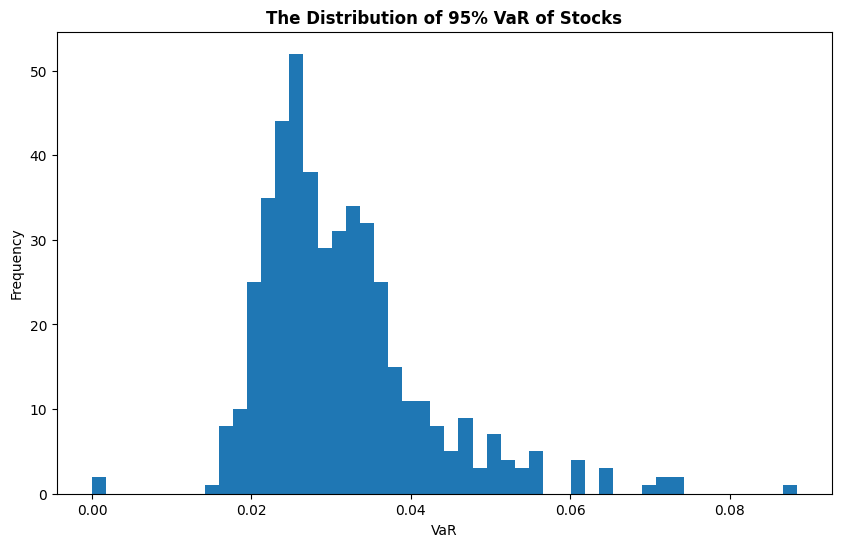

In [131]:
# Visualizing VaR distribution of Fortune 500 Stocks
plt.figure(figsize = (10, 6))
plt.hist(
    VaR_df[f'VaR_{confidence_level}'],
    bins = 50
)
plt.title(f'The Distribution of {int(100*confidence_level)}% VaR of Stocks', fontweight = 'bold')
plt.ylabel('Frequency')
plt.xlabel('VaR')
plt.show()

#### Conditional VaR (CVaR/ES)

It measures the average loss beyond the VaR threshold, at a given confidence interval $\alpha$.

$\mathrm{CVaR}_{\alpha} = - \mathbb{E}\!\left[\, r \mid r \le \mathrm{VaR}_{\alpha} \,\right]$

In [132]:
# CVaR computation
confidence_level = 0.95
alpha = 1 - confidence_level

CVaR_dict = {}

for ticker, df in feature_data.items():
    returns = df['log_return_1d']

    var_alpha = np.percentile(returns, alpha * 100)
    cvar_confidence_level = returns[returns <= var_alpha].mean() 

    CVaR_dict[ticker] = -1 * cvar_confidence_level

CVaR_df = pd.DataFrame.from_dict(
    CVaR_dict,
    orient='index',
    columns = [f'CVaR_{confidence_level}']
).sort_values(f'CVaR_{confidence_level}', ascending = False)

CVaR_df

,CVaR_0.95
Carvana,0.139217
VF,0.136551
Community_Health_Systems,0.123217
QVC_Group,0.119855
Wayfair,0.106851
...,...
Coca-Cola,0.027007
Johnson_and_Johnson,0.026907
Kellanova,0.026583
Ace_Hardware,0.002499


In [137]:
# Merging VaR and CVaR results
risk_results = VaR_df.join(CVaR_df)

risk_results['Tail_Risk_Ratio'] = risk_results[f'CVaR_{confidence_level}'] / risk_results[f'VaR_{confidence_level}']
risk_results['Tail_Risk_Ratio'].replace((np.inf, -np.inf), 0, inplace=True)
risk_results.sort_values(by = 'Tail_Risk_Ratio', ascending = False)

risk_results

,VaR_0.95,CVaR_0.95,Tail_Risk_Ratio
Carvana,0.088425,0.139217,1.574396
Altice_USA,0.073840,0.106178,1.437957
Oscar_Health,0.072686,0.106641,1.467152
Community_Health_Systems,0.071887,0.123217,1.714050
Hertz_Global_Holdings,0.071378,0.097760,1.369607
...,...,...,...
Republic_Services,0.016357,0.028243,1.726688
Johnson_and_Johnson,0.016160,0.026907,1.665012
Coca-Cola,0.015711,0.027007,1.719037
Ace_Hardware,-0.000000,0.002499,0.000000


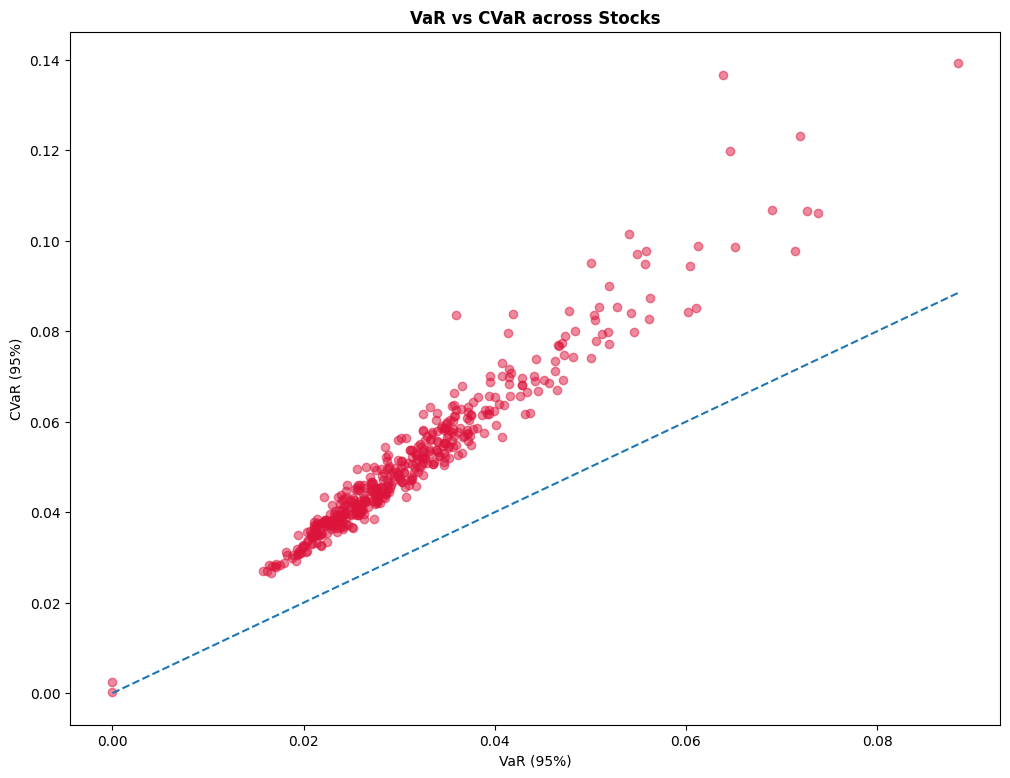

In [142]:
# Visualizing VaR vs CVaR
plt.figure(figsize=(12, 9))
plt.scatter(
    risk_results[f'VaR_{confidence_level}'],
    risk_results[f'CVaR_{confidence_level}'],
    alpha = 0.5,
    c = 'crimson'
)

plt.plot(
    risk_results[f'VaR_{confidence_level}'],
    risk_results[f'VaR_{confidence_level}'],
    linestyle = '--'
)

plt.xlabel(f'VaR ({int(100*confidence_level)}%)')
plt.ylabel(f'CVaR ({int(100*confidence_level)}%)')
plt.title('VaR vs CVaR across Stocks', fontweight = 'bold')
plt.show()

If $CVaR \approx VaR$, then thin tails & mild downside risk

else $CVaR \gt VaR$, then heavy tails, severe downside risk

#### EWMA (Exponentially Weighted Moving Average) Volatility

It is a method for estimating time-varying volatility in which recent returns receive more weight than older returns, wtih weights decaying exponentially. EWMA is a benchmark model, serving as a baseline for GARCH.

EWMA variance is: $\sigma_t^{2} = \lambda \sigma_{t-1}^{2} + (1 - \lambda)\, r_{t-1}^{2}$

EWMA volatility is: $\sigma_t = \sqrt{\sigma_t^{2}}$

In [148]:
# Computing EWMA volatility
lamb = 0.94 # Lambda -> decay factor -> higher lambda implies smoother volatility
annualization = np.sqrt(252) # 1 trading year
window_vol = 20

EWMA_dict = {}

for ticker, df in feature_data.items():
    df = df.copy()

    returns = df['log_return_1d']

    # Historical volatility
    df['hist_vol_20d'] = (
        returns
        .rolling(window_vol)
        .std()
        * annualization
    )

    # EWMA variance
    EWMA_var = np.zeros(len(returns))
    EWMA_var[0] = returns.var()

    for t in range(1, len(returns)):
        EWMA_var[t] = (
            lamb * EWMA_var[t-1]
            + (1-lamb) * returns.iloc[t-1]**2
        )
    
    df['EWMA_vol'] = np.sqrt(EWMA_var) * annualization
    EWMA_dict[ticker] = df

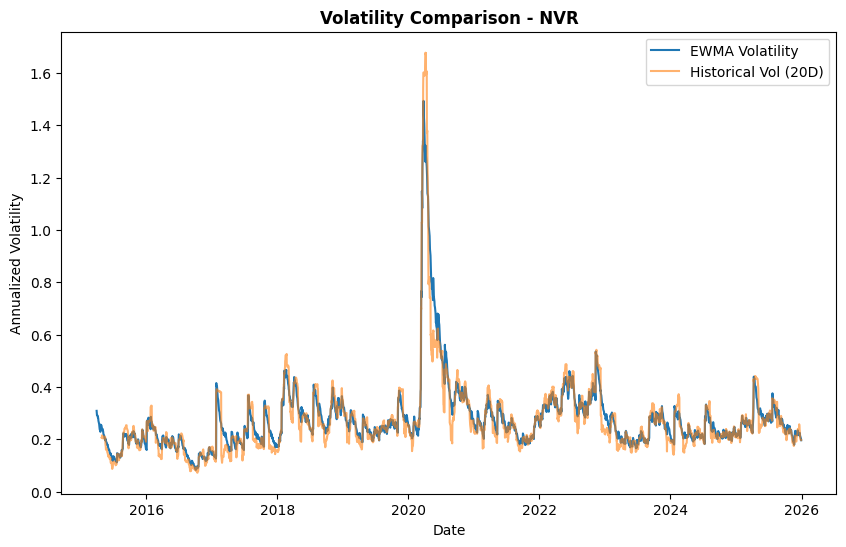

In [152]:
# Visualizing EWMA vs. Historical Volatility
sample_ticker = list(EWMA_dict.keys())[0]
sample_df = EWMA_dict[sample_ticker]

plt.figure(figsize=(10,6))
plt.plot(
    sample_df['Date'],
    sample_df['EWMA_vol'],
    label = 'EWMA Volatility'
)

plt.plot(
    sample_df['Date'],
    sample_df['hist_vol_20d'],
    label = 'Historical Vol (20D)',
    alpha = 0.6
)
plt.title(f'Volatility Comparison - {sample_ticker}', fontweight = 'bold')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.legend(loc = 'best')
plt.show()

EWMA has faster shock response than historical volatility, and smoother decay after shock spikes.

#### GARCH (General Autoregressive Conditional Heteroskedasticity) Modeling

GARCH is a time-series model used to estimate and forecast time-varying volatility, especially in financial return series. 

The main assumption is that volatility is not constant over time, and tends to cluster periods of high volatility that are followed by high volatility, and calm period followed by calm periods. This implies the returns having near-zero autocorrelation as well as squared & absolute returns. Therefore, GARCH model capture the volatility clustering.

#### GARCH(1,1) Model

Let $r_{t}$ be the return at time $t$.

$\textbf{Mean equation:}$

$r_t = \mu + \varepsilon_t$

$\textbf{Variance equation:}$

$\varepsilon_t = \sigma_t z_t, \quad z_t \sim \mathcal{N}(0,1)$

$\sigma_t^{2} = \omega + \alpha \varepsilon_{t-1}^{2} + \beta \sigma_{t-1}^{2}$


##### Where:
- $\sigma_t^2$ = conditional variance ($volatility^{2}$)
- $\omega > 0$ = long-run variance level
- $\alpha$ = reaction to new shocks
- $\beta$ = persistence of past volatility





In [165]:
# estimating GARCH model
sample_ticker = list(feature_data.keys())[0]
df = feature_data[sample_ticker].copy()

returns = df['log_return_1d'] * 100 # rescaled to improve numerical stability
returns = returns.dropna()
returns

# fitting GARCH model
garch = arch_model(
    returns,
    mean = 'Constant',
    vol = 'GARCH',
    p = 1, 
    q = 1, 
    dist = 'normal'
)

garch_result = garch.fit(disp = 'off')
print(garch_result.summary())

# calculating volatility persistence
alpha = garch_result.params['alpha[1]']
beta = garch_result.params['beta[1]']
print(f'Volatility Persistence: {(alpha + beta):.4f}')

                     Constant Mean - GARCH Model Results                      
Dep. Variable:          log_return_1d   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5264.17
Distribution:                  Normal   AIC:                           10536.3
Method:            Maximum Likelihood   BIC:                           10559.9
                                        No. Observations:                 2705
Date:                Fri, Jan 16 2026   Df Residuals:                     2704
Time:                        19:43:42   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0762  3.119e-02      2.442  1.460e-02 [1.504e-0